In [ ]:
# Mount Google Drive, load API keys for Quandl, and set up environment variables for API access
from google.colab import drive
import json

drive.mount('/content/drive')

from pathlib import Path
HDF_PATH = Path('drive', 'MyDrive', 'ML4T', 'data.h5')

Mounted at /content/drive


# Statistical Inference of Stock Returns with Linear Regression

In this section, we will perform statistical inference of stock returns using linear regression.


## Imports & Settings


In [ ]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
idx = pd.IndexSlice


## Load Data



In [ ]:
# Load data from the HDF5 file
with pd.HDFStore(HDF_PATH) as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))


## Select Investment Universe

We will filter the data to include only the top 100 most liquid stocks based on the dollar volume rank.


In [ ]:
# Filter the data for the top 100 most liquid stocks
data = data[data.dollar_vol_rank < 100]

# Display information about the filtered data including null counts
data.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109748 entries, (Timestamp('2013-07-03 00:00:00'), 'AAL') to (Timestamp('2014-12-10 00:00:00'), 'ZTS')
Data columns (total 65 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   volume                  109748 non-null  float64
 1   dollar_vol              109748 non-null  float64
 2   dollar_vol_1m           109748 non-null  float64
 3   dollar_vol_rank         109748 non-null  float64
 4   rsi                     109748 non-null  float64
 5   bb_high                 109748 non-null  float64
 6   bb_low                  109748 non-null  float64
 7   atr                     109748 non-null  float64
 8   macd                    109748 non-null  float64
 9   return_1d               109748 non-null  float64
 10  return_5d               109748 non-null  float64
 11  return_10d              109748 non-null  float64
 12  return_21d              109748 non-null  float64
 13 

## Create Model Data

In this section, we prepare the model data by separating the target variables and the features.


In [ ]:
# Separate the target variables
y = data.filter(like='target')

# Drop the target variables and other unnecessary columns from the features
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume'], axis=1)


## Explore Data

We will explore the data by visualizing the correlation matrix of the target variables.


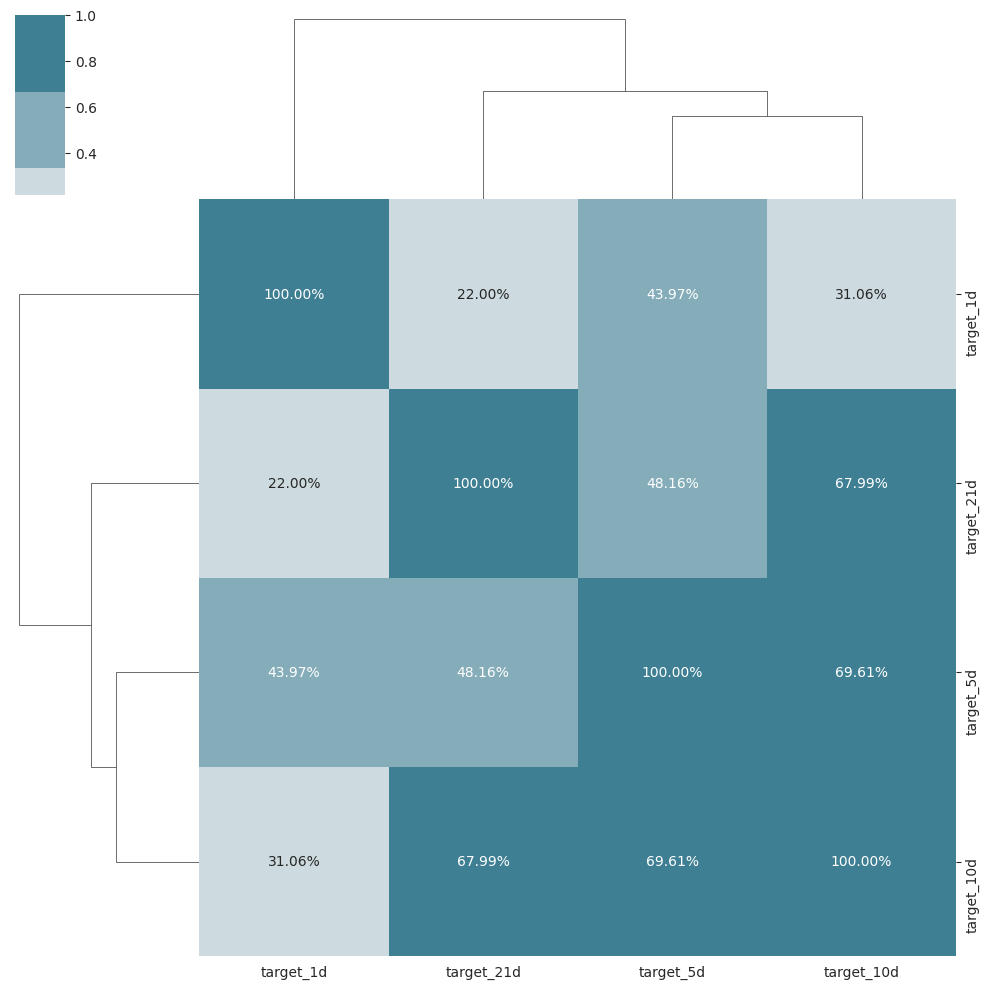

In [ ]:
# Plot the correlation matrix of the target variables
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%')
plt.show()


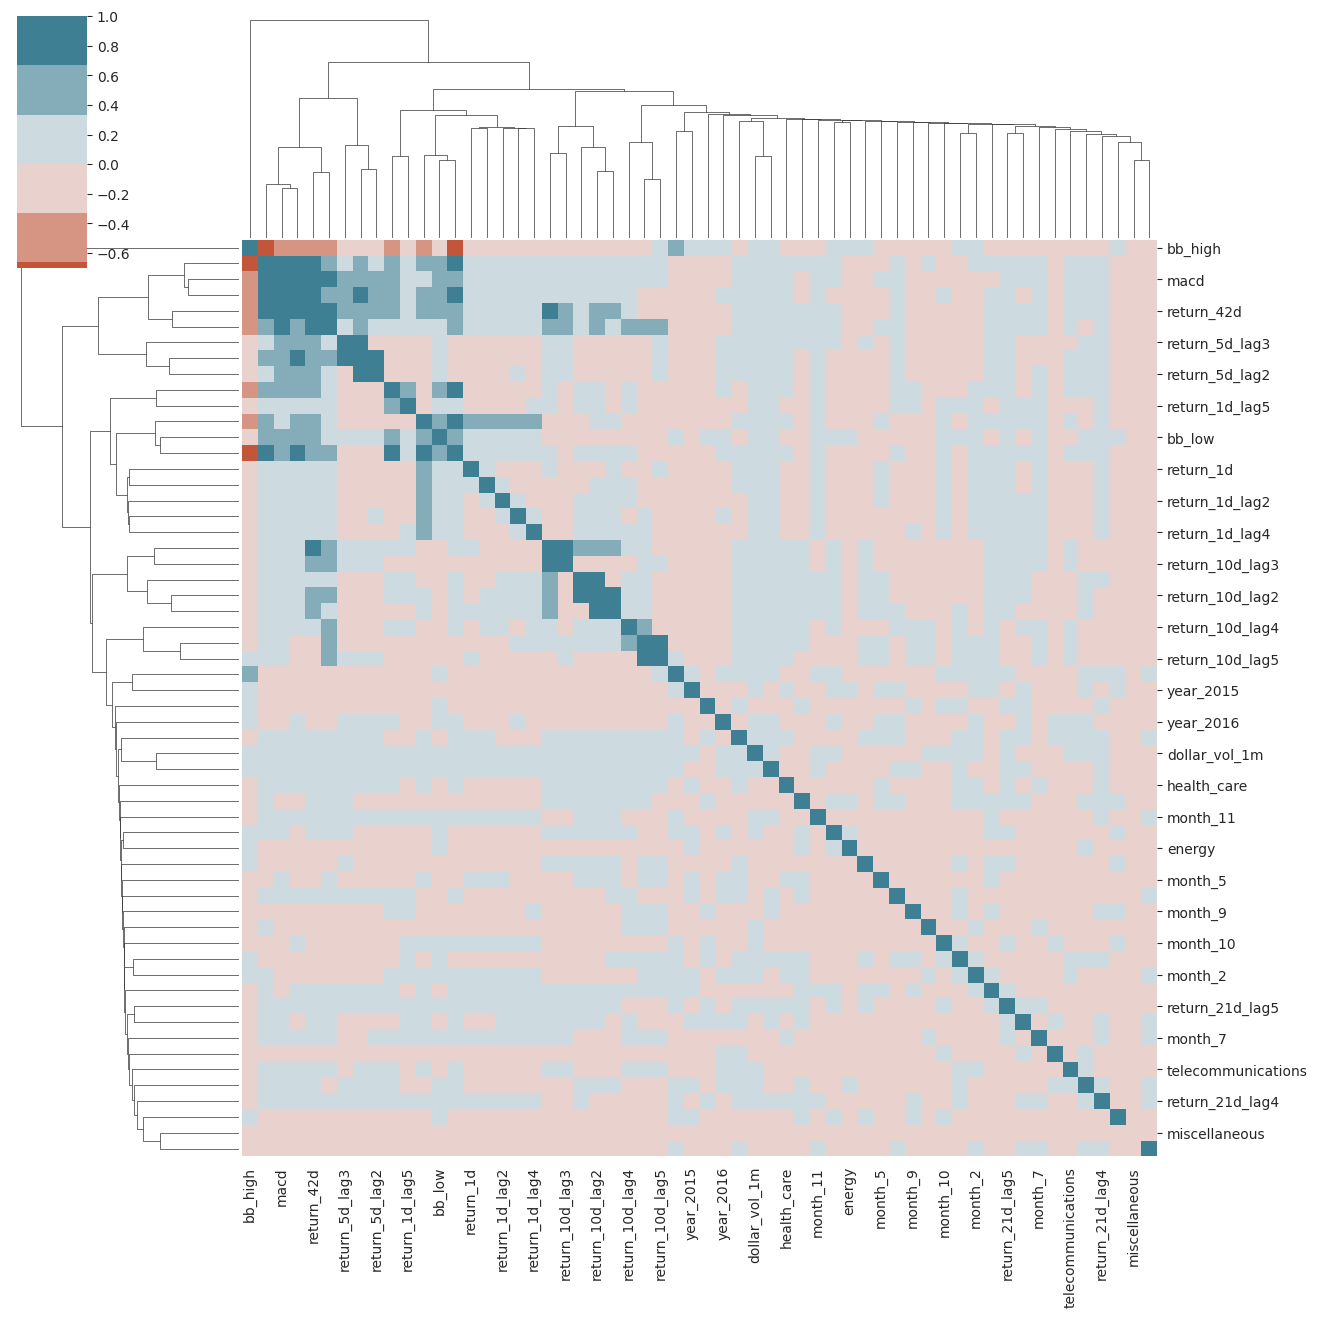

In [ ]:
# Calculate the correlation matrix of the features and fill NaN values with zeros
corr_matrix = X.corr().fillna(0)

# Plot the correlation matrix of the features
sns.clustermap(corr_matrix, cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0)
plt.gcf().set_size_inches((14, 14))
plt.show()


In [ ]:
# Calculate the correlation matrix of the features
corr_mat = X.corr().stack().reset_index()

# Rename the columns for better readability
corr_mat.columns = ['var1', 'var2', 'corr']

# Filter out self-correlations and sort by correlation values
corr_mat = corr_mat[corr_mat.var1 != corr_mat.var2].sort_values(by='corr', ascending=False)

# Display the top and bottom correlations
top_bottom_corr = pd.concat([corr_mat.head(), corr_mat.tail()])
top_bottom_corr


,var1,var2,corr
637,return_63d,return_42d,0.829634
581,return_42d,return_63d,0.829634
286,macd,rsi,0.818752
62,rsi,macd,0.818752
518,return_21d,macd,0.813256
515,return_21d,bb_high,-0.646894
122,bb_high,return_10d,-0.700760
458,return_10d,bb_high,-0.700760
59,rsi,bb_high,-0.703528
115,bb_high,rsi,-0.703528


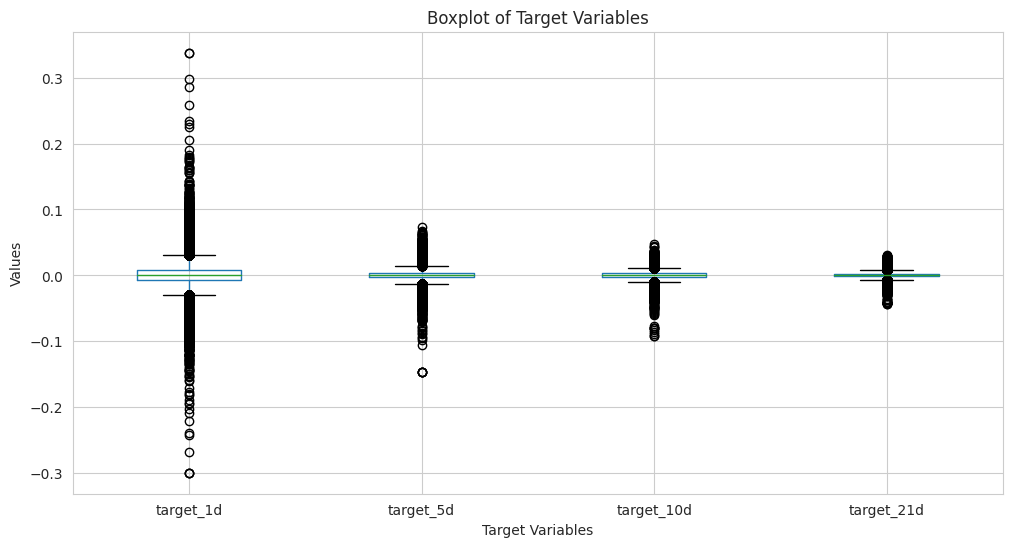

In [ ]:
# Visualize the distribution of the target variables using a boxplot
plt.figure(figsize=(12, 6))
y.boxplot()
plt.title('Boxplot of Target Variables')
plt.xlabel('Target Variables')
plt.ylabel('Values')
plt.show()


## Linear Regression for Statistical Inference: OLS with Statsmodels

We will perform linear regression for statistical inference using OLS with the statsmodels library.


### Ticker-wise Standardization

We standardize the features ticker-wise to avoid high design matrix condition numbers which can arise due to scaling differences.


In [ ]:
import numpy as np

# Separate the sector dummy variables
sectors = X.iloc[:, -10:]

# Standardize the features ticker-wise and rejoin the sector dummy variables
X_standardized = (X.drop(sectors.columns, axis=1)
                  .groupby(level='ticker')
                  .transform(lambda x: (x - x.mean()) / x.std())
                  .join(sectors)
                  .fillna(0))

# Ensure that all values are numeric
X_standardized = X_standardized.apply(pd.to_numeric, errors='coerce')
y = y.apply(pd.to_numeric, errors='coerce')

# Replace non-finite values with NaNs
X_standardized.replace([np.inf, -np.inf], np.nan, inplace=True)
y.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaNs in both X and y to ensure alignment
X_finite, y_finite = X_standardized.align(y, join='inner', axis=0)
X_finite.dropna(inplace=True)
y_finite.dropna(inplace=True)

# Convert boolean columns to integers
X_finite = X_finite.astype(float).apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Check for non-finite values
print(np.isfinite(X_finite.values).all())
print(np.isfinite(y_finite.values).all())


True
True


### 1-Day Returns

We will perform linear regression to analyze 1-day returns.


In [ ]:
# Define the target variable
target = 'target_1d'

# Ensure there are no non-finite values in X and y
y_finite_target = y_finite[target]

# Check for non-finite values
print(np.isfinite(X_finite.values).all())
print(np.isfinite(y_finite_target.values).all())

# Create and fit the OLS model
model = OLS(endog=y_finite_target.values, exog=add_constant(X_finite.values))
trained_model = model.fit()

# Print the summary of the trained model
print(trained_model.summary())


True
True
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     19.29
Date:                Fri, 02 Aug 2024   Prob (F-statistic):          1.66e-188
Time:                        09:25:33   Log-Likelihood:             2.9303e+05
No. Observations:              109748   AIC:                        -5.859e+05
Df Residuals:                  109691   BIC:                        -5.854e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006   9.79e-05      5.65

### 5-Day Returns

We will perform linear regression to analyze 5-day returns.


In [ ]:
# Define the target variable
target = 'target_5d'

# Ensure there are no non-finite values in X and y
y_finite_target = y_finite[target]

# Check for non-finite values
print(np.isfinite(X_finite.values).all())
print(np.isfinite(y_finite_target.values).all())

# Create and fit the OLS model
model = OLS(endog=y_finite_target.values, exog=add_constant(X_finite.values))
trained_model = model.fit()

# Print the summary of the trained model
print(trained_model.summary())


True
True
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     66.97
Date:                Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                        09:28:03   Log-Likelihood:             3.8323e+05
No. Observations:              109748   AIC:                        -7.663e+05
Df Residuals:                  109691   BIC:                        -7.658e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004    4.3e-05      9.34

## Obtain the Residuals

In this section, we will obtain the residuals from the trained model and analyze their distribution and autocorrelation.


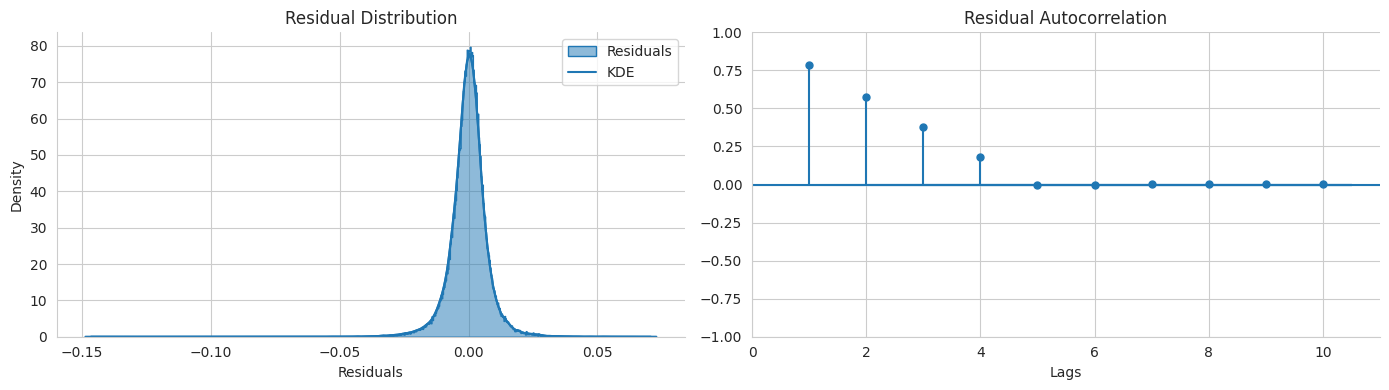

In [ ]:
# Obtain the predictions from the trained model
preds = trained_model.predict(add_constant(X_finite))

# Calculate the residuals
residuals = y_finite[target] - preds

# Create subplots to visualize the residuals
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))

# Plot the distribution of the residuals
sns.histplot(residuals, kde=True, ax=axes[0], stat="density", element="step", label='Residuals')
sns.kdeplot(residuals, ax=axes[0], label='KDE')
axes[0].set_title('Residual Distribution')
axes[0].set_xlabel('Residuals')
axes[0].legend()

# Plot the autocorrelation function of the residuals
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')

# Remove the top and right spines from the plots
sns.despine()

# Adjust the layout of the figure
fig.tight_layout()

plt.show()


### 10-Day Returns

We will perform linear regression to analyze 10-day returns.


In [ ]:
# Define the target variable
target = 'target_10d'

# Ensure there are no non-finite values in X and y
y_finite_target = y_finite[target]

# Check for non-finite values
print(np.isfinite(X_finite.values).all())
print(np.isfinite(y_finite_target.values).all())

# Create and fit the OLS model
model = OLS(endog=y_finite_target.values, exog=add_constant(X_finite.values))
trained_model = model.fit()

# Print the summary of the trained model
print(trained_model.summary())


True
True
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     94.42
Date:                Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                        09:30:57   Log-Likelihood:             4.2371e+05
No. Observations:              109748   AIC:                        -8.473e+05
Df Residuals:                  109691   BIC:                        -8.468e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   2.98e-05     12.44

### Monthly Returns

We will perform linear regression to analyze monthly returns (21-day returns).


In [ ]:
# Define the target variable
target = 'target_21d'

# Ensure there are no non-finite values in X and y
y_finite_target = y_finite[target]

# Check for non-finite values
print(np.isfinite(X_finite.values).all())
print(np.isfinite(y_finite_target.values).all())

# Create and fit the OLS model
model = OLS(endog=y_finite_target.values, exog=add_constant(X_finite.values))
trained_model = model.fit()

# Print the summary of the trained model
print(trained_model.summary())


True
True
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     141.3
Date:                Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                        09:31:33   Log-Likelihood:             4.6737e+05
No. Observations:              109748   AIC:                        -9.346e+05
Df Residuals:                  109691   BIC:                        -9.341e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      2e-05     18.73